RFM Framework
* Recency: When is the last time does the user take this action?
* Frequency: How many times does the user take this action?
* Monetary: What is the sum of monetary value from this user throughout his/her lifetime?

## 1. Prepare the dataset to calculate R-F-M


In [1]:
import pandas as pd
import numpy as np
from numpy import median
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
orders = pd.read_excel("Dataset.xlsx", sheet_name = "Orders")
product = pd.read_excel("Dataset.xlsx", sheet_name = "Product")
location = pd.read_excel("Dataset.xlsx", sheet_name = "Location")
customer = pd.read_excel("Dataset.xlsx", sheet_name = "Customer")
refund = pd.read_excel("Dataset.xlsx", sheet_name = "Return")

customer = pd.DataFrame(customer)
orders = pd.DataFrame(orders)
product = pd.DataFrame(product)
location = pd.DataFrame(location)
refund = pd.DataFrame(refund)


* Check NA in datasets

In [4]:
na_in_orders = orders.isna().sum().any()
print(na_in_orders)

na_in_product = product.isna().sum().any()
print(na_in_product)

na_in_location = location.isna().sum().any()
print(na_in_location)

na_in_customer = customer.isna().sum().any()
print(na_in_customer)

na_in_refund = refund.isna().sum().any()
print(na_in_refund)

False
False
False
False
False


* Check duplicates in datasets

In [5]:
print(orders.duplicated().sum())
print(product.duplicated().sum())
print(location.duplicated().sum())
print(customer.duplicated().sum())
print(refund.duplicated().sum())

0
0
0
0
0


* Merge datasets to get a final dataset for RFM calculation

In [3]:
orders = orders[["Row ID", "Order ID", "Order Date", "Ship Date", "Ship Mode", "Customer ID", "Channel",
                 "Sales", "Quantity", "Unit Cost"]]
customer = customer[["Customer ID", "Customer Name"]]
product = product[["Row ID", "Category", "Sub-Category"]]
location = location[["Row ID", "Country", "State"]]


return_order = orders['Order ID'].isin(refund['Order ID'])
orders.drop(orders[return_order].index, inplace = True)

profile = orders.merge(customer, how = 'left', on = 'Customer ID')
profile

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Channel,Sales,Quantity,Unit Cost,Customer Name
0,646,CA-2017-126221,2017-12-30,2018-01-05,Standard Class,CC-12430,Home Office,209.300,2,76.3945,Chuck Clark
1,907,CA-2017-143259,2017-12-30,2018-01-03,Standard Class,PO-18865,Consumer,323.136,4,77.7546,Patrick O'Donnell
2,908,CA-2017-143259,2017-12-30,2018-01-03,Standard Class,PO-18865,Consumer,90.930,7,12.6003,Patrick O'Donnell
3,909,CA-2017-143259,2017-12-30,2018-01-03,Standard Class,PO-18865,Consumer,52.776,3,10.9950,Patrick O'Donnell
4,5092,CA-2017-156720,2017-12-30,2018-01-03,Standard Class,JM-15580,Consumer,3.024,3,1.2096,Jill Matthias
...,...,...,...,...,...,...,...,...,...,...,...
9189,1760,CA-2014-141817,2014-01-05,2014-01-12,Standard Class,MB-18085,Consumer,19.536,3,4.8840,Mick Brown
9190,740,CA-2014-112326,2014-01-04,2014-01-08,Standard Class,PO-19195,Home Office,11.784,3,2.5041,Phillina Ober
9191,741,CA-2014-112326,2014-01-04,2014-01-08,Standard Class,PO-19195,Home Office,272.736,3,112.5036,Phillina Ober
9192,742,CA-2014-112326,2014-01-04,2014-01-08,Standard Class,PO-19195,Home Office,3.540,2,4.5135,Phillina Ober


## 2. Calculate R, F, M

In [4]:
# Create the RFM table

now = dt.datetime(2017,12,31)
RFM_table = profile.groupby('Customer ID').agg({
                                                'Order Date': lambda x: (now - x.max()).days, # Recency
                                                'Order ID': lambda x: len(x.unique()), # Frequency
                                                'Sales': lambda x: x.sum()})    # Monetary 
RFM_table['Order Date'] = RFM_table['Order Date'].astype(int)

RFM_table.rename(columns={'Order Date': 'Recency', 
                         'Order ID': 'Frequency',
                         'Sales': 'Monetary'}, inplace=True)
RFM_table

,Recency,Frequency,Monetary
Customer ID,,,
AA-10315,185,5,5563.560
AA-10375,20,9,1056.390
AA-10480,260,4,1790.512
AA-10645,483,5,5073.975
AB-10015,416,3,886.156
...,...,...,...
XP-21865,83,9,2110.726
YC-21895,5,4,5438.650
YS-21880,10,8,6720.444


In [5]:
# Calculate RFM Scores

r_labels, f_labels, m_labels = range(5,0,-1), range(1,6), range(1,6)

RFM_table['r_score'] = pd.qcut(RFM_table['Recency'], q = 5, labels = r_labels)
RFM_table['f_score'] = pd.qcut(RFM_table['Frequency'], q = 5, labels = f_labels)
RFM_table['m_score'] = pd.qcut(RFM_table['Monetary'], q = 5, labels = m_labels)

In [6]:
RFM_table['RFM Score'] = RFM_table['r_score'].astype(str) + RFM_table['f_score'].astype(str) + RFM_table['m_score'].astype(str)
RFM_table['RFM Score'] = RFM_table['RFM Score'].astype(int)
RFM_table

,Recency,Frequency,Monetary,r_score,f_score,m_score,RFM Score
Customer ID,,,,,,,
AA-10315,185,5,5563.560,2,2,5,225
AA-10375,20,9,1056.390,5,5,2,552
AA-10480,260,4,1790.512,2,1,3,213
AA-10645,483,5,5073.975,1,2,5,125
AB-10015,416,3,886.156,1,1,2,112
...,...,...,...,...,...,...,...
XP-21865,83,9,2110.726,3,5,3,353
YC-21895,5,4,5438.650,5,1,5,515
YS-21880,10,8,6720.444,5,4,5,545


## 3. Customer Segmentation

In [7]:
segmentation = pd.read_excel("Dataset.xlsx", sheet_name = "Segmentation")
segmentation['RFM Score'] = segmentation['RFM Score'].str.split(',')
segmentation = segmentation.explode('RFM Score').reset_index(drop = True)
segmentation['RFM Score'] = segmentation['RFM Score'].astype(int)
segmentation.sort_values(by = 'RFM Score')
segmentation 

,Segment,RFM Score
0,Champions,555
1,Champions,554
2,Champions,544
3,Champions,545
4,Champions,454
...,...,...
120,Lost customers,112
121,Lost customers,121
122,Lost customers,131
123,Lost customers,141


In [8]:
segment = RFM_table.merge(segmentation, how = 'left', on = 'RFM Score')
segment

,Recency,Frequency,Monetary,r_score,f_score,m_score,RFM Score,Segment
0,185,5,5563.560,2,2,5,225,At Risk
1,20,9,1056.390,5,5,2,552,Potential Loyalist
2,260,4,1790.512,2,1,3,213,About To Sleep
3,483,5,5073.975,1,2,5,125,At Risk
4,416,3,886.156,1,1,2,112,Lost customers
...,...,...,...,...,...,...,...,...
786,83,9,2110.726,3,5,3,353,Potential Loyalist
787,5,4,5438.650,5,1,5,515,Promising
788,10,8,6720.444,5,4,5,545,Champions
789,55,12,7892.998,4,5,5,455,Champions


## 4. Visualize customer segmentation

#### Distribution of Recency, Frequency, Monetary
* In this plot, we want to examine the median recency, frequency, and monetary value accross segments to determine which factor is the most important one among those three

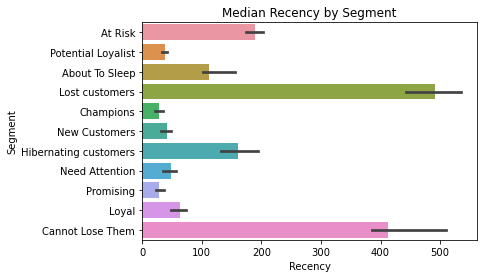

In [9]:
segment['Recency'].astype(int)
recency_dist = sns.barplot(x = segment['Recency'], y = segment['Segment'], estimator = median)
plt.title("Median Recency by Segment")
plt.show()

The Median Recency by Segment plot shows that the longer it takes for a customer to return to the store (the higher recency score), the less likely he or she is to return at all.  In this plot, we see that recently, the groups of customers are Lost customers, Cannot Lose Them and At Risk. This means, we should focus on marketing strategies, best seller products and customer groups to stimulate more sales to the At Risk group. However, we still see the good amount of customers in Cannot Lose Them group, which are valuable to the company.

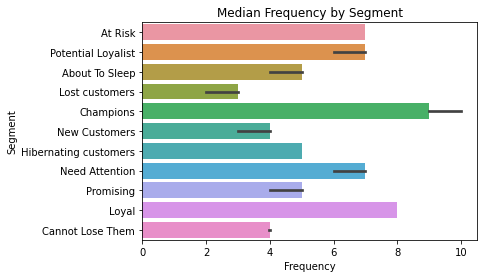

In [10]:
segment['Frequency'].astype(int)
freq_dist = sns.barplot(x = segment['Frequency'], y = segment['Segment'], estimator = median)
plt.title("Median Frequency by Segment")
plt.show()

The Median Frequency by Segment plot shows that which group of customers have purchased regularly during a specific period. In this plot, we see groups of Champions, Loyal and Need Attention are the most among other customer groups. This means that it is good to see the most profitable customers in the company.

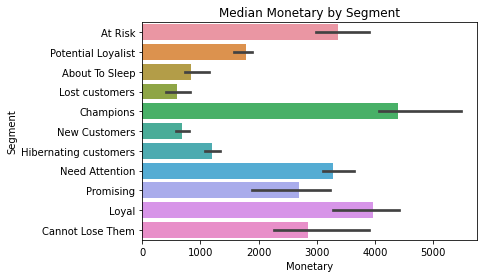

In [11]:
segment['Monetary'].astype(int)
monetary_dist = sns.barplot(x = segment['Monetary'], y = segment['Segment'], estimator = median)
plt.title("Median Monetary by Segment")
plt.show()

The Median Monetary by Segment plot shows customer behavior within the company. This plot aligns well with the Median Frequency by Segment plot because Champions and Loyal customers are customers with the highest monetary and purchase items frequently. 

#### Pie Chart of customer segmentations

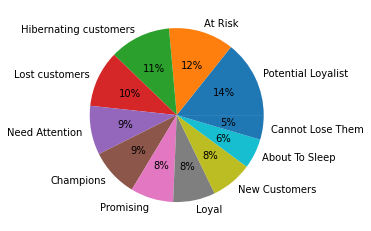

In [12]:
plt.pie(segment.Segment.value_counts(),
       labels = segment.Segment.value_counts().index,
       autopct='%.0f%%')
plt.show()

The pie chart shows that there are three most important customer segmentations that the company needs to pay attention to, which are: Potential Loyalist that constitute 14% of all customers, At Risk customers that constitute 12% of all customers and Hibernating customers that constitute 11% of all customers. It is good to see that overall, the company still keep a decent number of potential loyalists. However, seeing that the group of hibernating customers and at risk customers are big, the marketing department can reach out these groups by doing campaign and focus to the group "at risk" to increase customer retention.  

#### Relationship of RFM Score

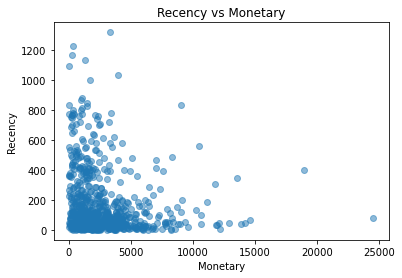

In [13]:
plt.scatter(x = segment['Monetary'], y = segment['Recency'], alpha = 0.5)
plt.title('Recency vs Monetary')
plt.xlabel('Monetary')
plt.ylabel('Recency')
plt.show()

Customer who cisted more recently generated more revenue compared to those who visited in the distant past. The customers who visited in the recent past are more likely to return compared to those who visited long time ago as most of those would be lost customers. Thus, higher revenue would be associated with most recent visits.

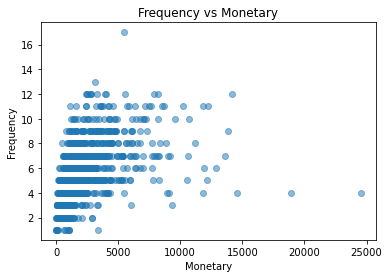

In [14]:
plt.scatter(x = segment['Monetary'], y = segment['Frequency'], alpha = 0.5)
plt.title('Frequency vs Monetary')
plt.xlabel('Monetary')
plt.ylabel('Frequency')
plt.show()

As the frequency of visits increases, the revenue generated also increases. Customers who visit more frequently are your champion customers, loyal customers or potential loyalists and they drive higher revenue. 

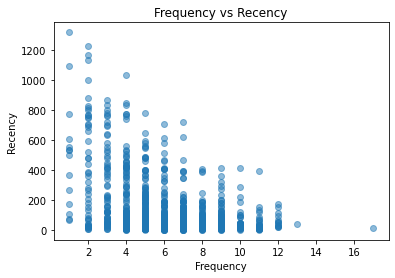

In [15]:
plt.scatter(x = segment['Frequency'], y = segment['Recency'], alpha = 0.5)
plt.title('Frequency vs Recency')
plt.xlabel('Frequency')
plt.ylabel('Recency')
plt.show()

Customers with low frequency visited in the distant past while those with high frequency have visited in the recent past. The customers who visited in the recent past are more likely to return compared to those who visited long time ago. Thus, higher frequency would be associated with the most recent visits. 

#### Which factor is the most important in RFM score?

Based on the above analysis of the RFM factors, recency is the most important factor to identify customers who are likely to respond to a new offer. Because customers who purchased more recently have a higher chance to purchase again than are customers who purchased further in the past. Once we optimize the recency factor, we can also maximize frequency and monetary score. 

# 5. Analyze Sales Trends 

### Which product categories drive the most revenue? (Monetary)

In [16]:
revenue = orders.merge(product, how = 'inner', on = 'Row ID')
revenue

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Channel,Sales,Quantity,Unit Cost,Category,Sub-Category
0,646,CA-2017-126221,2017-12-30,2018-01-05,Standard Class,CC-12430,Home Office,209.300,2,76.3945,Office Supplies,Paper
1,907,CA-2017-143259,2017-12-30,2018-01-03,Standard Class,PO-18865,Consumer,323.136,4,77.7546,Furniture,Bookcases
2,908,CA-2017-143259,2017-12-30,2018-01-03,Standard Class,PO-18865,Consumer,90.930,7,12.6003,Office Supplies,Art
3,909,CA-2017-143259,2017-12-30,2018-01-03,Standard Class,PO-18865,Consumer,52.776,3,10.9950,Furniture,Chairs
4,1878,CA-2017-118885,2017-12-29,2018-01-02,Standard Class,JG-15160,Consumer,393.568,4,109.4611,Technology,Machines
...,...,...,...,...,...,...,...,...,...,...,...,...
1715,594,CA-2014-135405,2014-01-09,2014-01-13,Standard Class,MS-17830,Consumer,31.200,3,7.1500,Office Supplies,Envelopes
1716,1760,CA-2014-141817,2014-01-05,2014-01-12,Standard Class,MB-18085,Consumer,19.536,3,4.8840,Office Supplies,Art
1717,740,CA-2014-112326,2014-01-04,2014-01-08,Standard Class,PO-19195,Home Office,11.784,3,2.5041,Office Supplies,Storage
1718,741,CA-2014-112326,2014-01-04,2014-01-08,Standard Class,PO-19195,Home Office,272.736,3,112.5036,Office Supplies,Binders


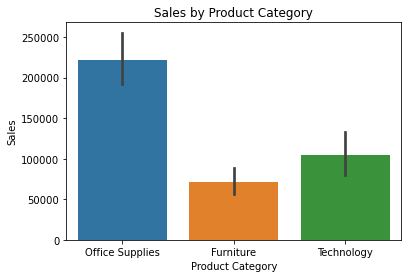

In [17]:
sns.barplot(x = 'Category', y = 'Sales', data = revenue, estimator = sum)
plt.xlabel('Product Category')
plt.title('Sales by Product Category')
plt.show()

In this plot, we observe that Office Supplies is the category that generates the most sales within the company, constitutes over 80% of overall sales in the company, and over 50% of Technology category. This means the company should focus their marketing strategies on Office Supplies to maximize their revenue, and at the same time, doing more advertising campagins or promotions on Technology category as this category is promising in sales.  

### Which channels drive the most revenue? (Monetary)

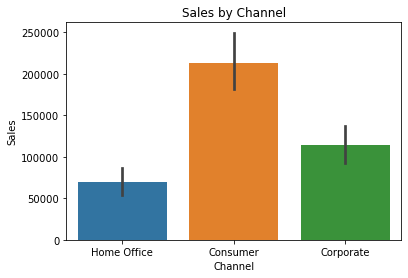

In [18]:
sns.barplot(x = 'Channel', y = 'Sales', data = revenue, estimator = sum)
plt.xlabel('Channel')
plt.title('Sales by Channel')
plt.show()

The plot above shows that Consumer Channel is the best channel to generate revenue, with over 200000 compared to Corporate with 120000 and Home Office with 70000, which is about 80% of overall sales in the company. Because our best product category is Office Supplies, this indicates our consumers are people who works in corporate jobs or in educational fields, retail or wholesale. This aligns well with the Sales by Product Category plot to help the company build appropriate strategies to focus more on consumer channel more than Home Office and Corporate to maximize the revenue. 

### Analyze sales trends over time (Recency vs Monetary)

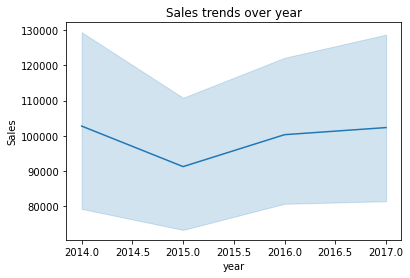

In [28]:
revenue['year'] = pd.to_datetime(revenue['Order Date']).dt.year
sns.lineplot(x = 'year', y = 'Sales', data = revenue, estimator = sum)
plt.title('Sales trends over year')
plt.show()

Based on this plot, we observe a down trend in sales over time from 2014 to 2015 from 10500 to 9000, which is about 20% decrease, then sales has increased from 2015 to 2017 from 9000 to 10000, which is about 10% increase. This indicates that there is a chance that sales will continue to increase from 2017. However, there is a slow increase in sales so we should focus more on most sales genrated product category and customer channel in order to determine the best marketing strategies to maximize our revenue. 

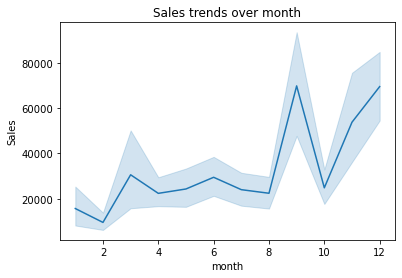

In [29]:
revenue['month'] = pd.to_datetime(revenue['Order Date']).dt.month
sns.lineplot(x = 'month', y = 'Sales', data = revenue, estimator = sum)
plt.title('Sales trends over month')
plt.show()

Based on this plot, we observe that sales in March, June, September and December are the highest over year, with 7000 is the highest revenue in September. This is because Spring semester in school mostly starts from March to June, while Fall semester in school mostly starts in September, and December is during holidays. This aligns well with the best seller product categeory, which is office supplies that target to students and people who works in corporate jobs. On the other hand, February and October generate the least sales of a whole year. 

### Which locations generate the most revenue?

In [20]:
place = orders.merge(location, how = 'inner', on = 'Row ID')
place

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Channel,Sales,Quantity,Unit Cost,Country,State
0,271,CA-2017-163979,2017-12-28,2018-01-02,Second Class,KH-16690,Corporate,725.840,4,128.8366,United States,Virginia
1,571,CA-2017-164826,2017-12-28,2018-01-04,Standard Class,JF-15415,Consumer,72.450,7,5.3820,United States,Washington
2,572,CA-2017-164826,2017-12-28,2018-01-04,Standard Class,JF-15415,Consumer,13.960,4,1.8846,United States,Illinois
3,573,CA-2017-164826,2017-12-28,2018-01-04,Standard Class,JF-15415,Consumer,33.264,7,3.1482,United States,Florida
4,574,CA-2017-164826,2017-12-28,2018-01-04,Standard Class,JF-15415,Consumer,14.850,3,3.6135,United States,Colorado
...,...,...,...,...,...,...,...,...,...,...,...,...
560,158,CA-2014-104269,2014-03-01,2014-03-06,Second Class,DB-13060,Consumer,457.568,2,203.0458,United States,Ohio
561,457,US-2014-110674,2014-02-12,2014-02-18,Standard Class,SC-20095,Consumer,129.568,2,76.9310,United States,Texas
562,541,CA-2014-140795,2014-02-01,2014-02-03,First Class,BD-11500,Consumer,468.900,6,43.7640,United States,Utah
563,593,CA-2014-135405,2014-01-09,2014-01-13,Standard Class,MS-17830,Consumer,9.344,2,4.0880,United States,New Jersey


In [27]:
# Create table with state and sales
revenue_location = place.groupby('State')['Sales'].sum()
revenue_location = pd.DataFrame(revenue_location)
revenue_location = revenue_location.sort_values(by = 'Sales', ascending = False)
revenue_location.head(5)

,Sales
State,
Florida,21494.7140
California,15773.1628
Michigan,11603.3860
Arizona,10009.8660
Texas,8661.0270


Based on the results, there are 5 states that generate the most revenue in the company, which are Florida, California, Michigan, Arizona, and Texas. These locations are among the biggest states in the United States with a large number of populations. Florida has the highest revenue which is nearly 22000, about 17% of overall sales in the United States. 

## 6. Recommendations

Based on the RFM analysis conclusion, Recency is the most important factor to focus on because customers who purchased more recently have a higher chance to purchase again than are customers who purchased further in the past. Once we optimize the recency factor, we can also maximize frequency and monetary score.

Although Office Supplies generates the most revenue, technology can be a promising category to generate more sales in the future. The company can consider doing more marketing strategies to advertise related products to technology to target more customer channels. 

In the meantime, consumer channel is the best channel to generate revenue, with over 200000 in total sales. Because our best product category is Office Supplies, this indicates our consumers are people who works in corporate jobs or in educational fields, retail or wholesale. This aligns well with the Sales by Product Category plot to help the company build appropriate strategies to focus more on consumer channel more than Home Office and Corporate to maximize the revenue.

When observing overall sales over time, we observe a slow increase trend from 2017 to present. Thus, we should focus more on most sales genrated product category and customer channel in order to determine the best marketing strategies to maximize our revenue. Furthermore, March, June, September and December are the peak time to generate the most revenue over the year, so we can consider doing campaigns or promotions to maximize sales. 

Lastly, Florida, California, Michigan, Arizona, and Texas are among the best states to generate sales of the United States. Therefore, we can consider pushing best seller product category to target customers during peak time to maximize sales. 